In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fontTools.misc.arrayTools import scaleRect
from sklearn.preprocessing import MinMaxScaler
import causallib

In [15]:
df = pd.read_csv("/Users/danmizrahi/Desktop/causalInference/CausalInferenceProject/Simulation/Training_data_3000.csv", index_col=0)
df = pd.get_dummies(df, dtype=float)
df

,Prior,b_mean_E,b_mean_N,b_mean_S,b_mean_W,b_std_E,b_std_N,b_std_S,b_std_W,d_E,d_N,d_S,d_W,T,Y
0,10194.59,1.030772,0.983781,0.990791,0.921146,0.033123,0.071297,0.046838,0.061928,479,447,506,419,2,29170.83
1,6406.34,0.984971,0.924783,0.904248,1.046082,0.079525,0.055213,0.028621,0.137850,342,368,339,388,0,6168.31
2,10178.21,1.019699,0.919077,1.089345,1.083659,0.132676,0.071688,0.021367,0.064772,432,455,473,440,0,10672.61
3,30058.77,1.020655,1.014600,0.996519,0.910000,0.149903,0.138777,0.091112,0.000000,504,487,540,534,2,33087.13
4,246748.77,0.983023,0.940251,0.907566,1.092754,0.014569,0.142431,0.039735,0.034851,655,637,608,708,2,48271.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,8396.41,0.983417,0.919912,0.942494,0.904096,0.058103,0.088731,0.066859,0.033494,357,452,437,415,0,9496.51
2996,15842.65,1.103051,0.944819,1.073242,0.987733,0.191734,0.168382,0.165628,0.188172,554,525,546,525,2,37675.97
2997,10921.98,0.909739,1.065268,1.016647,0.973642,0.079671,0.116973,0.112241,0.028926,459,503,501,475,0,10025.24
2998,26874.97,1.002509,1.066973,0.918544,1.070139,0.078001,0.004681,0.029384,0.003633,570,522,515,576,2,35478.76


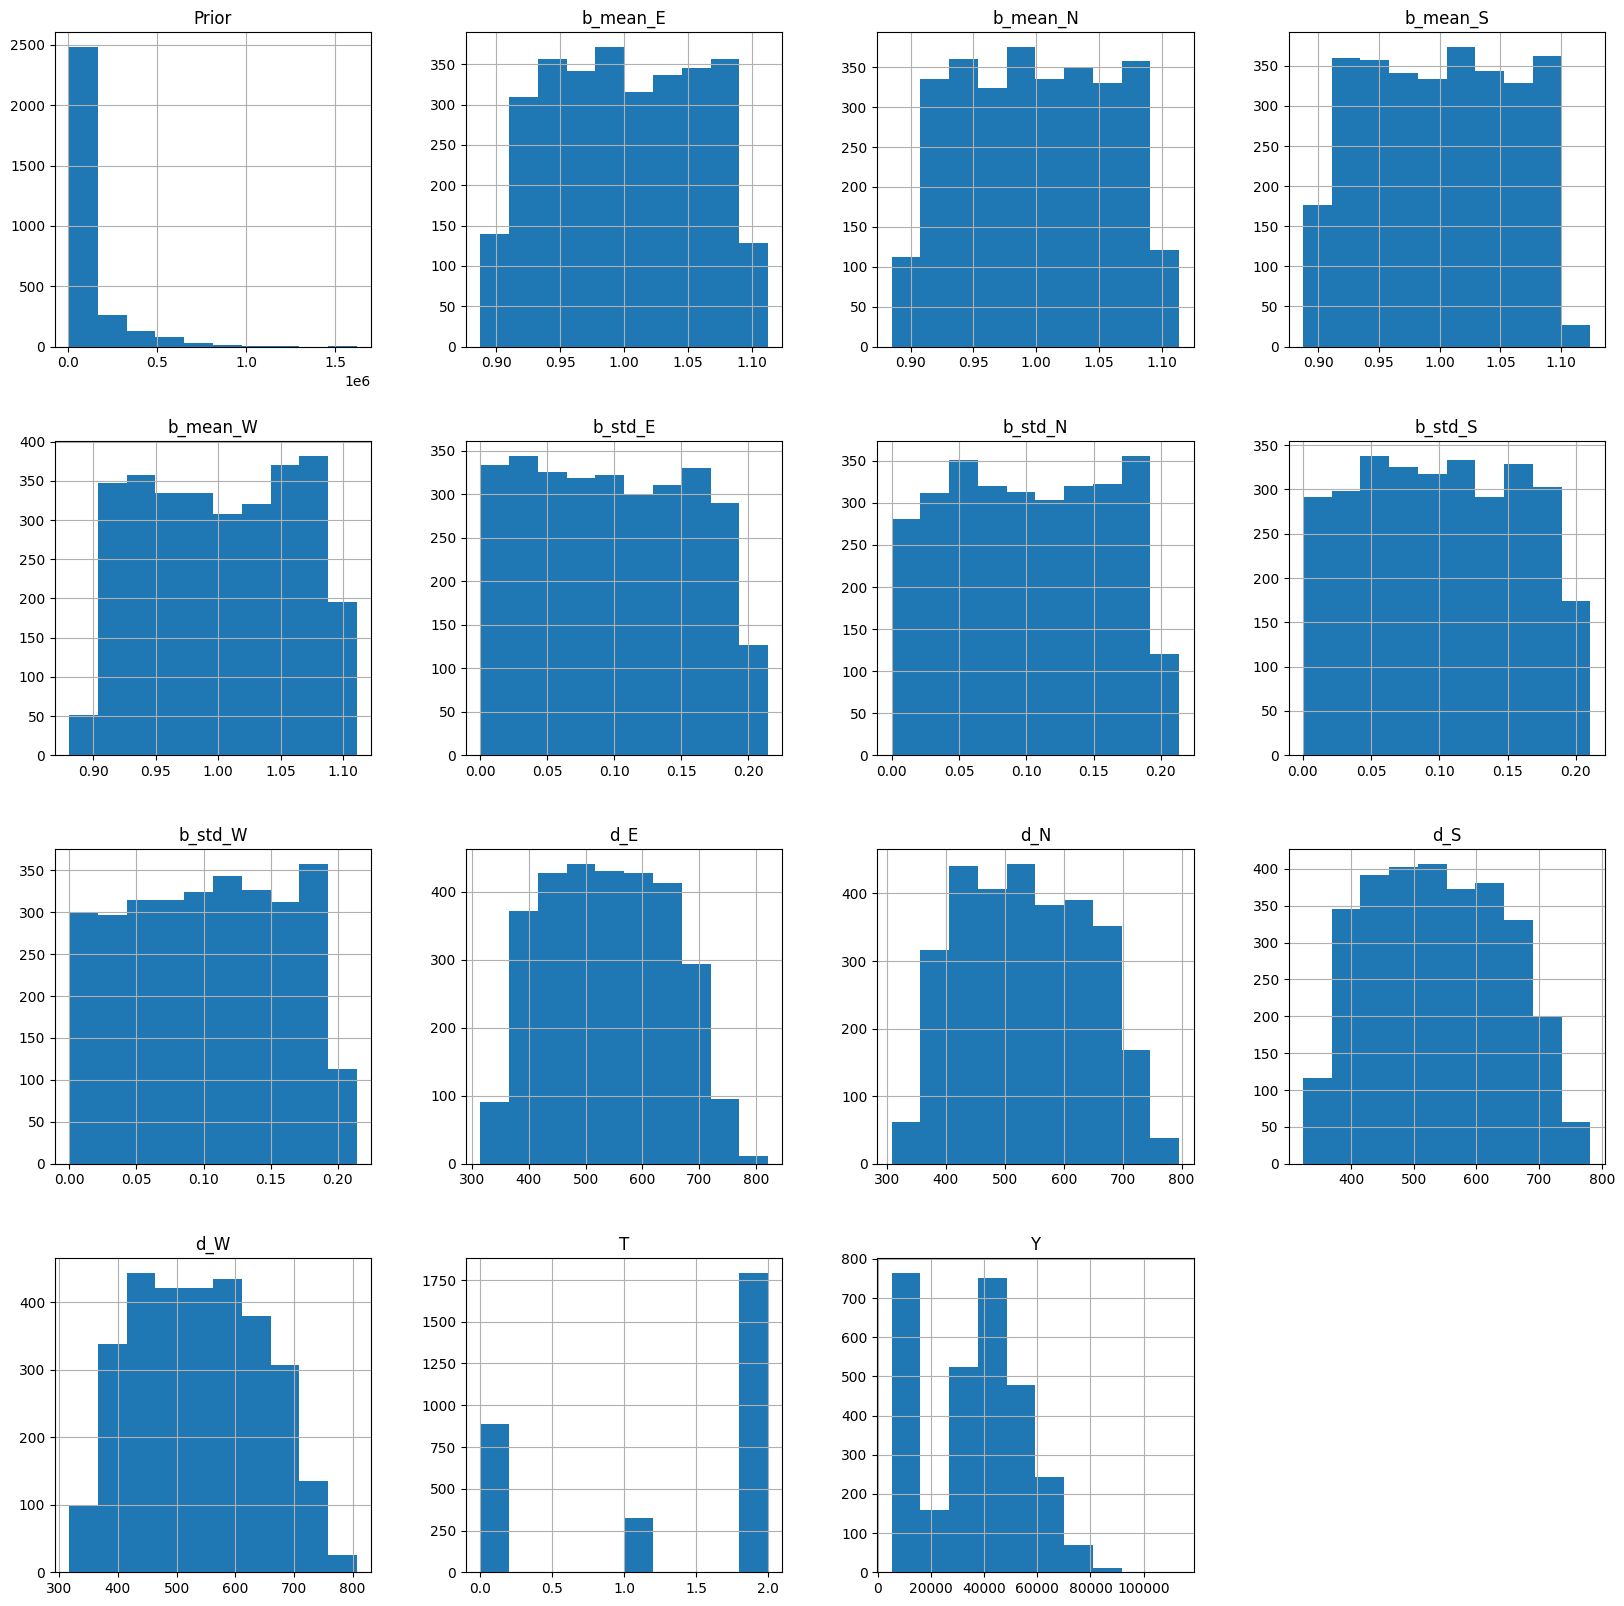

In [16]:
df.hist(figsize=(20, 20))
plt.show()

In [17]:
cols_to_scale = ['Prior', 'b_mean_E', 'b_mean_N', 'b_mean_S', 'b_mean_W', 'b_std_E',
       'b_std_N', 'b_std_S', 'b_std_W', 'd_E', 'd_N', 'd_S']
scale = MinMaxScaler()

In [18]:
df_scaled = df.copy()
df_scaled[cols_to_scale] = scale.fit_transform(df_scaled[cols_to_scale])
df_scaled

,Prior,b_mean_E,b_mean_N,b_mean_S,b_mean_W,b_std_E,b_std_N,b_std_S,b_std_W,d_E,d_N,d_S,d_W,T,Y
0,0.003380,0.635612,0.431611,0.436643,0.174991,0.154077,0.333669,0.222236,0.289267,0.324111,0.284836,0.398693,419,2,29170.83
1,0.001039,0.432275,0.174316,0.071144,0.718351,0.369928,0.258397,0.135801,0.643903,0.053360,0.122951,0.034858,388,0,6168.31
2,0.003370,0.586452,0.149433,0.852871,0.881775,0.617172,0.335503,0.101382,0.302554,0.231225,0.301230,0.326797,440,0,10672.61
3,0.015656,0.590695,0.566015,0.460835,0.126518,0.697308,0.649478,0.432304,0.000000,0.373518,0.366803,0.472767,534,2,33087.13
4,0.149572,0.423628,0.241775,0.085157,0.921330,0.067771,0.666581,0.188535,0.162791,0.671937,0.674180,0.620915,708,2,48271.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.002269,0.425379,0.153072,0.232672,0.100843,0.270278,0.415262,0.317230,0.156450,0.083004,0.295082,0.248366,415,0,9496.51
2996,0.006870,0.956492,0.261696,0.784863,0.464586,0.891894,0.788030,0.785862,0.878959,0.472332,0.444672,0.485839,525,2,37675.97
2997,0.003829,0.098281,0.786985,0.545843,0.403303,0.370609,0.547437,0.532553,0.135114,0.284585,0.399590,0.387800,475,0,10025.24
2998,0.013688,0.510135,0.794420,0.131520,0.822974,0.362841,0.021909,0.139421,0.016969,0.503953,0.438525,0.418301,576,2,35478.76


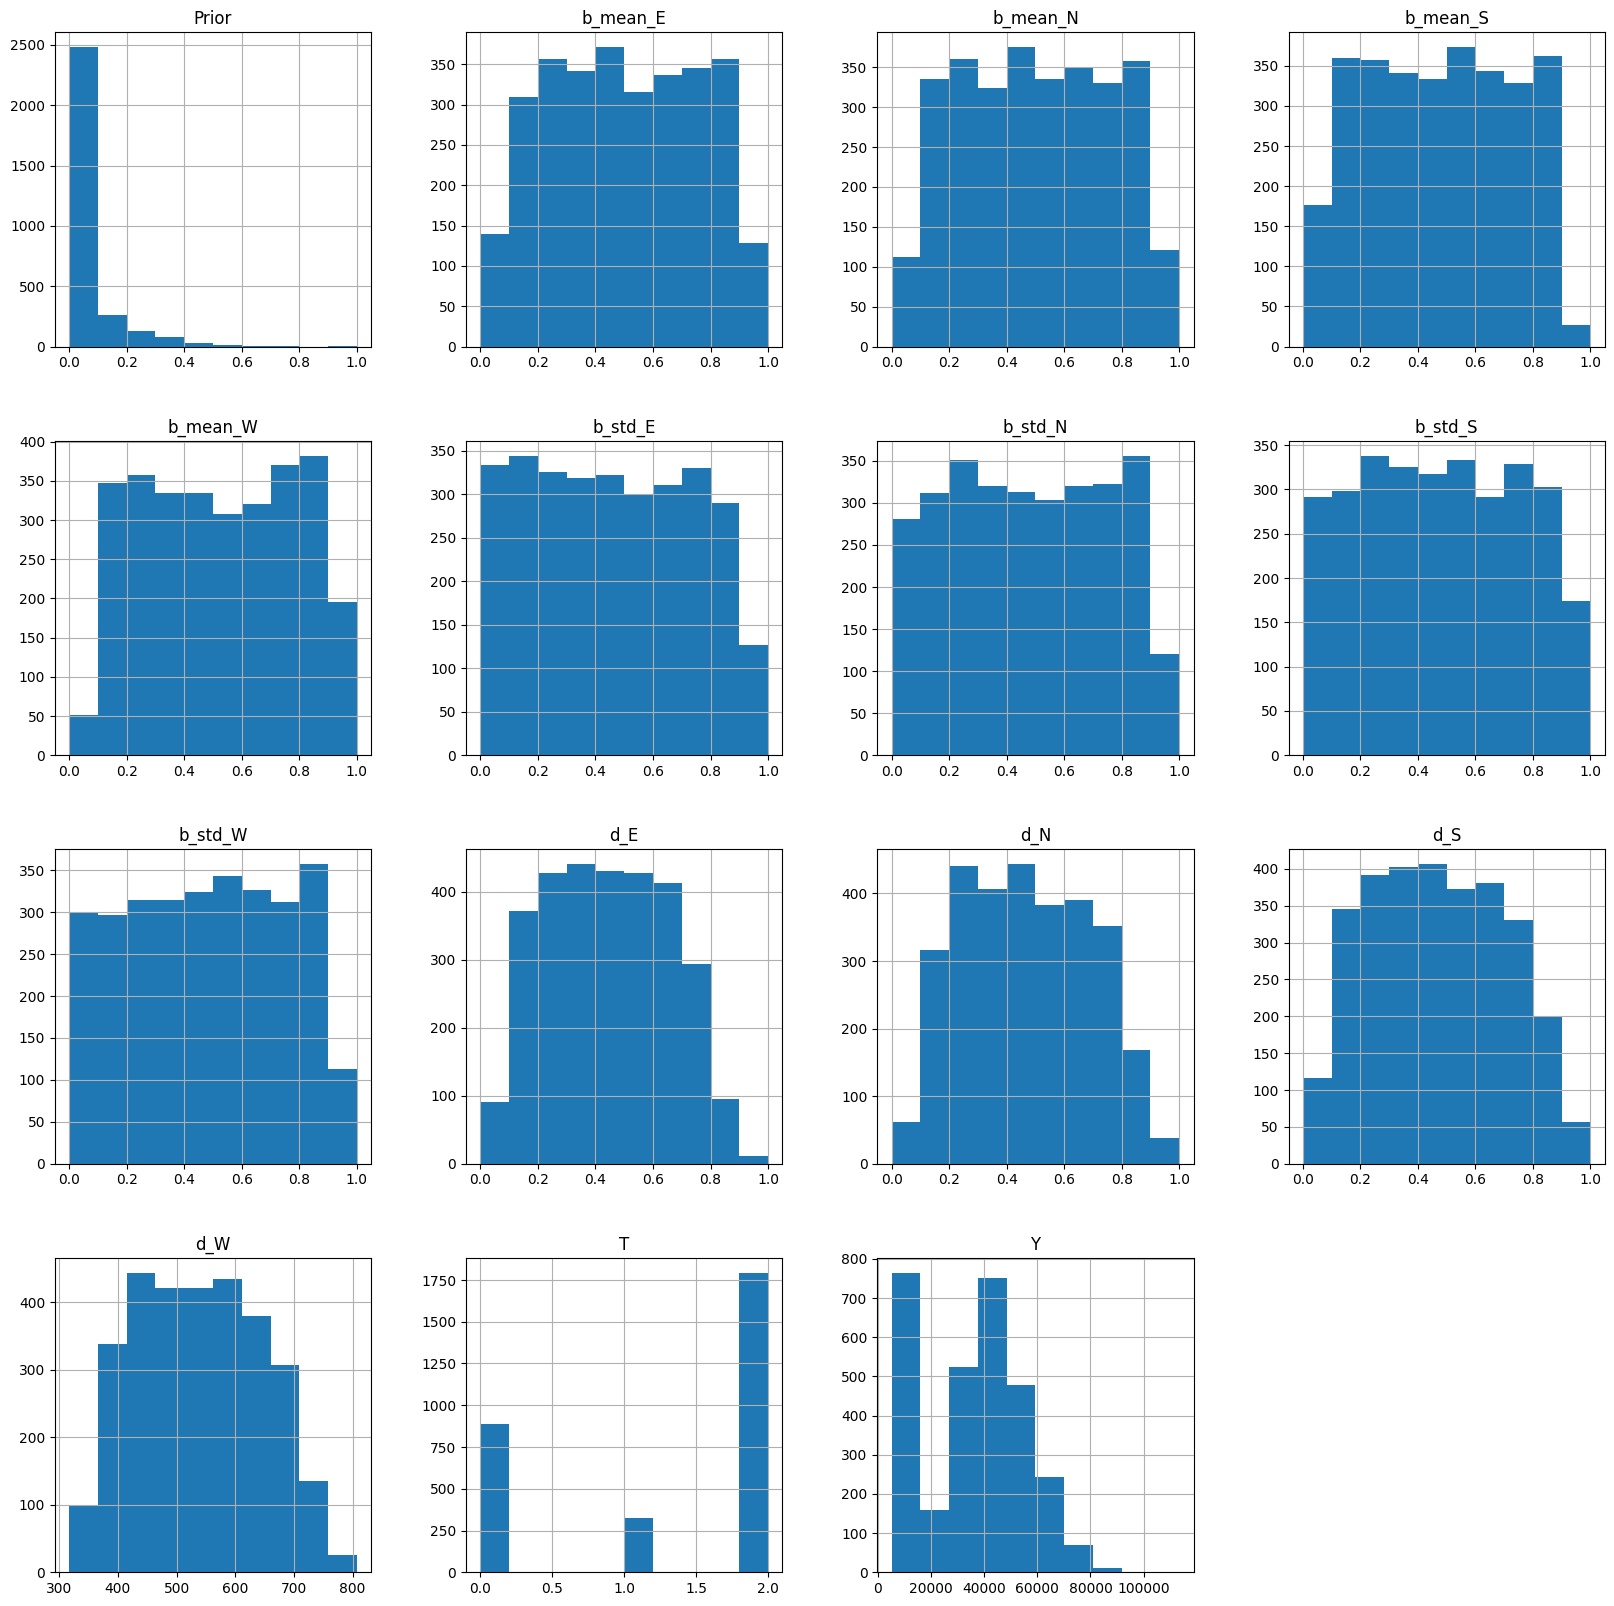

In [19]:
df_scaled.hist(figsize=(20, 20))
plt.show()